# Get the image datas

We download International Skin Imaging Collaboration Archive
thanks to a script made by Oren Talmor & Gal Avineri available at the following address: https://github.com/GalAvineri/ISIC-Archive-Downloader 



In [0]:
! git clone https://github.com/GalAvineri/ISIC-Archive-Downloader

Cloning into 'ISIC-Archive-Downloader'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 288
Receiving objects: 100% (289/289), 72.01 KiB | 317.00 KiB/s, done.
Resolving deltas: 100% (175/175), done.


In [0]:
! python ISIC-Archive-Downloader/download_archive.py --num-images 1000 --filter benign

You have decided to do the following:
Download maximum of 137 elements
start with offset 200
filter only benign images
Descriptions will be downloaded to /content/Data/Descriptions
Images will be downloaded to /content/Data/Images
Use 8 processes to download the archive
Do you confirm your choices? [Y/n] y
Benigns Found: 100% 137/137 [02:34<00:00,  1.14it/s]
Found 137 benign images
Finished downloading


In [0]:
! python ISIC-Archive-Downloader/download_archive.py --num-images 1000 --filter malignant

You have decided to do the following:
Download maximum of 137 elements
start with offset 200
filter only malignant images
Descriptions will be downloaded to /content/Data/Descriptions
Images will be downloaded to /content/Data/Images
Use 8 processes to download the archive
Do you confirm your choices? [Y/n] y
Malignants Found:   0% 0/137 [00:00<?, ?it/s]y
Malignants Found:  73% 100/137 [05:12<00:42,  1.15s/it]y
y
y
y
Malignants Found: 100% 137/137 [14:05<00:00,  1.84s/it]
Found 137 malignant images
Finished downloading


In [0]:
! tar -xvf imgs_test.tar.xz

imgs_test/
imgs_test/img_0000100.jpg
imgs_test/img_0000101.jpg
imgs_test/img_0000102.jpg
imgs_test/img_0000103.jpg
imgs_test/img_0000104.jpg
imgs_test/img_0000105.jpg
imgs_test/img_0000107.jpg
imgs_test/img_0000108.jpg
imgs_test/img_0000109.jpg
imgs_test/img_0000110.jpg
imgs_test/img_0000111.jpg
imgs_test/img_0000112.jpg
imgs_test/img_0000113.jpg
imgs_test/img_0000114.jpg
imgs_test/img_0000115.jpg
imgs_test/img_0000116.jpg
imgs_test/img_0000117.jpg
imgs_test/img_0000118.jpg
imgs_test/img_0000119.jpg
imgs_test/img_0000120.jpg
imgs_test/img_0000121.jpg
imgs_test/img_0000122.jpg
imgs_test/img_0000123.jpg
imgs_test/img_0000124.jpg
imgs_test/img_0000125.jpg
imgs_test/img_0000126.jpg
imgs_test/img_0000127.jpg
imgs_test/img_0000128.jpg
imgs_test/img_0000129.jpg
imgs_test/img_0000130.jpg
imgs_test/img_0000131.jpg
imgs_test/img_0000132.jpg
imgs_test/img_0000133.jpg
imgs_test/img_0000134.jpg
imgs_test/img_0000135.jpg
imgs_test/img_0000136.jpg
imgs_test/img_0000137.jpg
imgs_test/img_0000138.jpg
i

# Dataset creation

### Imports

In [0]:
# Magic number for tensorflow version (We want tensorflow keras !)
%tensorflow_version 2.x
# Tensorflow Keras and image preprocessing
import tensorflow as tf
# Read images and descriptor
import os
import cv2
import json
# Stock & display the images and desc
import numpy as np
from matplotlib import pyplot as plt
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# One hot
from tensorflow.keras.utils import to_categorical

TensorFlow 2.x selected.


### Check images

Tests:

1. directory
2. shape

In [0]:
def display_img(img):
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()
  return 

def load_img(path):
  return cv2.imread(path)

img = load_img("Data/Images/ISIC_0000200.jpeg")
display_img(img)

In [0]:
img.shape

(670, 962, 3)

### Create train and validation

In [0]:
from tensorflow.keras.applications import InceptionV3

In [0]:
def preprocess(image, height, width, central_fraction=0.875):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.central_crop(image, central_fraction=central_fraction)
  image = tf.expand_dims(image, 0)
  image = tf.image.resize(image, [height, width])
  image = tf.squeeze(image, [0])
  image = tf.subtract(image, 0.5)
  image = tf.multiply(image, 2.0)
  image.set_shape([height, width, 3])
  return image

In [0]:
def load_dataset(path, type):
  # Path for files
  pathimg = path + "Images/"
  if (type == "test"):
    pathimg = path
  pathdesc = path + "Descriptions/"
  # Content of files directories
  files = sorted(os.listdir(pathimg))
  files_desc = ""
  if (type != "test"):
    files_desc = sorted(os.listdir(pathdesc))
  # Numpy array to contain the information (x, y)
  imgs = np.zeros((len(files), 229, 229, 3))
  descs = np.zeros((len(files), 1))
  # Dictionnary to translate class into numerical value
  translate = {"benign" : 0, "malignant" : 1}
  # Read the files, preprocess images and store images & descriptions
  for i in range(0, len(files)):
    img = cv2.imread(pathimg + files[i])
    imgs[i] = preprocess(img, 229, 229)
    if (type == "test"):
      continue
    with open(pathdesc + files_desc[i], 'r') as jfile:
      desc = json.load(jfile)
      descs[i] = translate[desc['meta']['clinical']['benign_malignant']]
  return imgs, descs

In [0]:
images, descriptions = load_dataset("/content/Data/", "train")

In [0]:
(descriptions.shape, images.shape)

((274, 1), (274, 229, 229, 3))

In [0]:
train_lim = int(np.floor(0.7 * len(images)))

images_train = images[:train_lim]
descriptions_train = descriptions[:train_lim]

images_val = images[train_lim:]
descriptions_val = descriptions[train_lim:]

### Data augmentation & one_hot outputs

From Paper :

*During training, images are augmented by a factor of 720. each image is rotated randomly between 0° and 359°. The largest upright inscribed rectangle is then cropped from the image, and is flipped vertically with a probability of 0.5.*

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=359,
    vertical_flip=True)

# compute quantities required for featurewise normalization
datagen.fit(images_train)

In [0]:
descriptions_train_hot = to_categorical(descriptions_train)
descriptions_val_hot = to_categorical(descriptions_val)

# Model building

As in the following paper: 

Esteva, A., Kuprel, B., Novoa, R. et al. Dermatologist-level classification of skin cancer with deep neural networks. Nature 542, 115–118 (2017). https://doi.org/10.1038/nature21056

We will fine-tune an Inception-v3 network

### Imports

In [0]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD

### Base model

In [0]:
base_model = InceptionV3(include_top = False, weights='imagenet')

87916544/87910968 [==============================] - 8s 0us/step


### Callback for visualisation

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    print(logs)
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

### Function to display loss and accuracy

In [0]:
def loss_visu(batch_stats, hist):
  plt.figure()
  plt.ylabel("Loss")
  plt.xlabel("Training Steps")

  maxval = np.max(hist['val_loss'])
  maxtrain = np.max(batch_stats.batch_losses)
  max = maxval if maxval > maxtrain else maxtrain
  plt.ylim([0, max])

  plt.plot(batch_stats.batch_losses)
  plt.plot(hist['val_loss'], 'r')
  plt.show()

def acc_visu(batch_stats, hist):
  plt.figure()
  plt.ylabel("Accuracy")
  plt.xlabel("Training Steps")

  maxval = np.max(hist['val_acc'])
  maxtrain = np.max(batch_stats.batch_losses)
  max = maxval if maxval > maxtrain else maxtrain
  plt.ylim([0,max])

  plt.plot(batch_stats.batch_acc)
  plt.plot(hist['val_acc'], 'r')
  plt.show()

### Fine-tune InceptionV3

#### Training new top layers

In [0]:
epochs = 70

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs = base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

# train the model on the new data for a few epochs
history = model.fit(datagen.flow(images_train, descriptions_train_hot, batch_size=720),
                    epochs=epochs, callbacks = [batch_stats_callback], validation_data=(images_val, descriptions_val_hot))

  ...
    to  
  ['...']
Train for 1 steps, validate on 83 samples
Epoch 1/70
{'batch': 0, 'size': 191, 'loss': 0.66999376, 'acc': 0.60209423}
1/1 [==============================] - 18s 18s/step - loss: 0.6700 - acc: 0.6021 - val_loss: 69.9615 - val_acc: 0.0000e+00
Epoch 2/70
{'batch': 0, 'size': 191, 'loss': 14.204715, 'acc': 0.71727747}
1/1 [==============================] - 2s 2s/step - loss: 14.2047 - acc: 0.7173 - val_loss: 8.6420 - val_acc: 0.0000e+00
Epoch 3/70
{'batch': 0, 'size': 191, 'loss': 1.509252, 'acc': 0.71727747}
1/1 [==============================] - 2s 2s/step - loss: 1.5093 - acc: 0.7173 - val_loss: 0.1070 - val_acc: 1.0000
Epoch 4/70
{'batch': 0, 'size': 191, 'loss': 1.4871898, 'acc': 0.2827225}
1/1 [==============================] - 3s 3s/step - loss: 1.4872 - acc: 0.2827 - val_loss: 0.9112 - val_acc: 0.0602
Epoch 5/70
{'batch': 0, 'size': 191, 'loss': 0.644477, 'acc': 0.6753927}
1/1 [==============================] - 2s 2s/step - loss: 0.6445 - acc: 0.6754 - val_

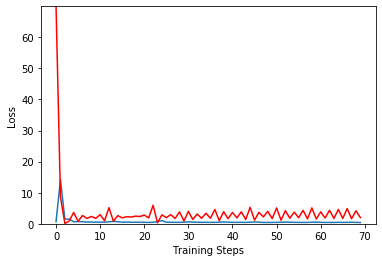

In [0]:
loss_visu(batch_stats_callback, history.history)

In [0]:
acc_visu(batch_stats_callback, history.history)

In [0]:
testimages, testdescriptions = load_dataset("/content/imgs_test/", "test")

In [0]:
! python ISIC-Archive-Downloader/download_archive.py --images-dir /Test/Images --descs-dir /Test/Descriptions --num-images 100 --offset 100 --p 8

You have decided to do the following:
Download maximum of 100 elements
start with offset 100
Use no filter (both benign and malignant)
Descriptions will be downloaded to /Test/Descriptions
Images will be downloaded to /Test/Images
Use 8 processes to download the archive
Do you confirm your choices? [Y/n] y
Found 100 images
Finished downloading


In [0]:
testim, testdesc = load_dataset("/Test/", "mdr")

In [0]:
mdr = model.predict(testim)

In [0]:
amdr = np.argmax(mdr, axis=1)

In [0]:
descmdr = np.argmax(to_categorical(testdesc), axis=1)

In [0]:
descmdr, amdr

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

In [0]:
len(amdr[amdr == descmdr])

60

In [0]:
predictions = model.predict(testimages)

In [0]:
predictions

array([[0.94936335, 0.0506366 ],
       [0.9903978 , 0.00960218],
       [0.87074375, 0.12925623],
       [0.9165647 , 0.0834353 ],
       [0.9479552 , 0.05204478],
       [0.96797794, 0.03202212],
       [0.9327213 , 0.06727868],
       [0.9166741 , 0.08332597],
       [0.87163645, 0.12836353],
       [0.973102  , 0.02689808],
       [0.9280653 , 0.07193462],
       [0.9338989 , 0.06610104],
       [0.95600575, 0.04399422],
       [0.9826811 , 0.01731896],
       [0.95516765, 0.04483232],
       [0.5966181 , 0.4033819 ],
       [0.9138202 , 0.0861798 ],
       [0.87033886, 0.12966111],
       [0.5370148 , 0.46298525],
       [0.96386606, 0.03613394],
       [0.8657662 , 0.13423379],
       [0.9705259 , 0.02947409],
       [0.92778224, 0.07221772],
       [0.8209985 , 0.17900145],
       [0.71319383, 0.2868062 ],
       [0.91813207, 0.08186795],
       [0.9562141 , 0.04378591],
       [0.9755588 , 0.02444117],
       [0.93570065, 0.06429934],
       [0.9236661 , 0.07633385],
       [0.

In [0]:
import pandas as pd

In [0]:
def predict_to_csv(file_list, predictions):
    dtest = pd.DataFrame()
    dtest["Nom de l image"] = sorted([file.split(".")[0] for file in file_list])
    dtest["Melanome ?"] = np.argmax(predictions, axis=1)
    dtest.to_csv("results.csv", index=False)


In [0]:
predict_to_csv(os.listdir("/content/imgs_test/"), predictions)